In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract-retweets(0)'
    '_keep-retweets(1)_negative-distance-threshold(0.8).point',
#     sep=' ',
    names=[
        'Topic', 'tweet_id',
        'Distance to query',
        'Distance to positive', 'Distance to negative',
        'Score',
        'retrieve', 'Positive', 'Negative',
        'Time',
    ],
    header=None,
    parse_dates=True,
    low_memory=False,
).dropna()

point['Time'] = point['Time'].cummax()

point = point.set_index(['Time', 'tweet_id', 'Topic']).unstack('Topic')

# point = pd.concat([point], axis=1, keys=['Point'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

point.columns.names = 'Variable', 'Topic'

point.size

7017088

In [8]:
topics = list(point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').columns.values)

In [9]:
# (
#     point['Distance to query'][topics]
#     .apply(np.vectorize(lambda v: v if v < 0.9 else None)).dropna(how='all')
#     .plot(style='o', use_index=False, figsize=(14, 6))
# );

In [10]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:5]

Variable                               Distance to query            \
Topic                                             RTS212     RTS48   
Time                tweet_id                                         
2017-07-29 18:44:27 891368843024715777          0.696413  0.957982   
2017-07-29 17:32:24 891350711023411200          0.697981  0.958169   
2017-07-29 17:05:36 891343966578372608          0.705152  1.000000   
2017-07-29 17:05:16 891343882683899904          0.705400  1.000000   
2017-07-29 17:33:24 891350962668920836          0.723867  1.000000   

Variable                               Distance to positive            \
Topic                                                RTS212     RTS48   
Time                tweet_id                                            
2017-07-29 18:44:27 891368843024715777             0.696413  0.941703   
2017-07-29 17:32:24 891350711023411200             0.697981  0.942077   
2017-07-29 17:05:36 891343966578372608             0.705152  0.976451   
2017-07-29 17:05:16 891343882683899904             0.705400  0.976473   
2017-07-29 17:33:24 891350962668920836             0.723867  0.972815   

Variable                               Distance to negative            \
Topic                                                RTS212     RTS48   
Time                tweet_id                                            
2017-07-29 18:44:27 891368843024715777             0.824429  0.887204   
2017-07-29 17:32:24 891350711023411200             0.826066  0.887937   
2017-07-29 17:05:36 891343966578372608             0.813649  0.976864   
2017-07-29 17:05:16 891343882683899904             0.813818  0.976886   
2017-07-29 17:33:24 891350962668920836             0.841175  0.965633   

Variable                                   Score           retrieve         \
Topic                                     RTS212     RTS48   RTS212  RTS48   
Time                tweet_id                                                 
2017-07-29 18:44:27 891368843024715777  0.870516  1.177129     True  False   
2017-07-29 17:32:24 891350711023411200  0.872477  1.177596     True  False   
2017-07-29 17:05:36 891343966578372608  0.881440  1.220564     True  False   
2017-07-29 17:05:16 891343882683899904  0.881750  1.220592     True  False   
2017-07-29 17:33:24 891350962668920836  0.904834  1.216018     True  False   

Variable                               Positive       Negative        \
Topic                                    RTS212 RTS48   RTS212 RTS48   
Time                tweet_id                                           
2017-07-29 18:44:27 891368843024715777        4     3        1     4   
2017-07-29 17:32:24 891350711023411200        3     2        1     4   
2017-07-29 17:05:36 891343966578372608        3     2        1     4   
2017-07-29 17:05:16 891343882683899904        3     2        1     4   
2017-07-29 17:33:24 891350962668920836        3     2        1     4   

Variable                               Relevance        
Topic                                     RTS212 RTS48  
Time                tweet_id                            
2017-07-29 18:44:27 891368843024715777       NaN   NaN  
2017-07-29 17:32:24 891350711023411200       NaN   NaN  
2017-07-29 17:05:36 891343966578372608       NaN   NaN  
2017-07-29 17:05:16 891343882683899904       NaN   NaN  
2017-07-29 17:33:24 891350962668920836       NaN   NaN

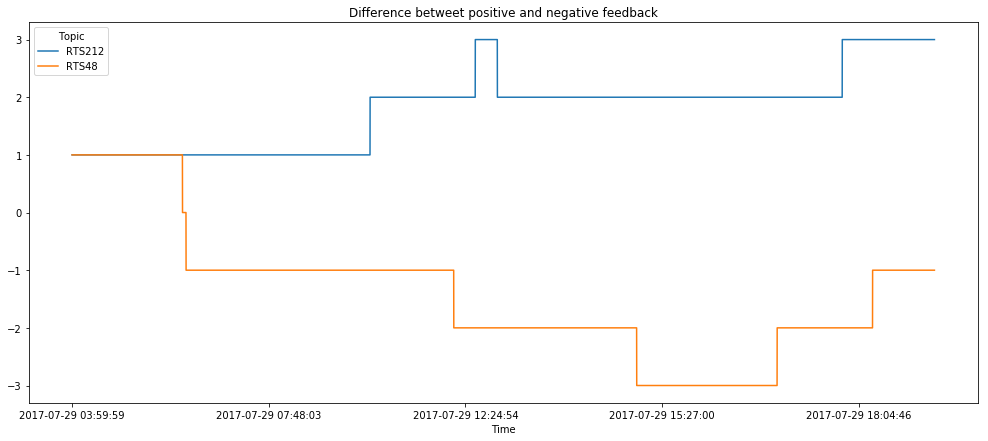

In [11]:
(
    (
        point['Positive']
        #point['retrieve'].cumsum()
        - point['Negative']
    )[topics]
#     .rolling(1_000).mean()
    .reset_index('tweet_id', drop=True).plot(
        title='Difference betweet positive and negative feedback',
        figsize=(17, 7),
    )
);

In [12]:
point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all')

Topic,RTS212,RTS48
-2.0,4.0,1
0.0,42.0,22
1.0,32.0,1
2.0,NaN,2


In [13]:
distance_score = (
    point[['Distance to query', 'Score', 'Relevance']]
    .stack('Topic')
    .dropna(subset=['Relevance'])
    .set_index('Relevance', append=True)
    .stack().to_frame('Value')
    .reset_index()
    .set_index(['Topic', 'tweet_id'])
)

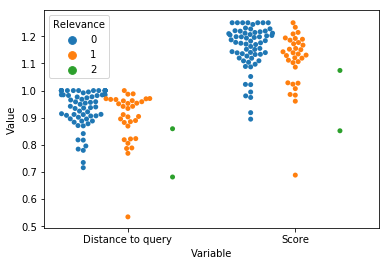

In [27]:
sns.swarmplot(
    data=distance_score, x='Variable', y='Value',hue='Relevance', hue_order=[0, 1, 2], dodge=True,
);

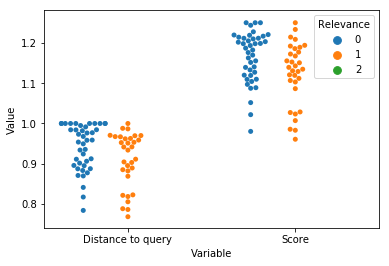

In [15]:
sns.swarmplot(
    data=distance_score.loc['RTS212'], x='Variable', y='Value', hue='Relevance', hue_order=[0, 1, 2], dodge=True
);

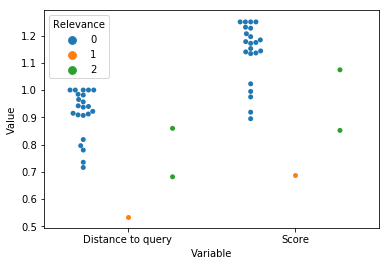

In [16]:
sns.swarmplot(
    data=distance_score.loc['RTS48'], x='Variable', y='Value', hue='Relevance', hue_order=[0, 1, 2], dodge=True
);

In [17]:
# point[['Distance to query', 'Score']].cummin().plot(use_index=False);

In [18]:
# point[['Distance to query', 'Score']].rolling(1_000_000, min_periods=1).min().plot(use_index=False);

In [19]:
point['Distance to query'].corrwith(point['Score'])

Topic
RTS212    0.566967
RTS48     0.701085
dtype: float64